# 109th Congress Data

This notebook is meant to call, clean, and examine data from the 2004 election, to produce a viable metric correlating PVI and electoral success.

It feeds into a larger project about fairness in redistricting; for instance, if an R+15 district is unattainable for a Democrat to win, then the district can be wholly classified as "safe," and should be bucketed with R+30 district.

The nuance enters in the margins. How safe is an R+6 district for instance? Can we quantify a district moving from R+3 to R+6 as a significant bias against Democrats? By cleaning this dataset, and others like it, we can determine the predictive power of PVI in each district, and use those probabilities later to assess redistricting fairness.

## Retrieve Data

Currently no free source contains a list of PVI and congressional maps. However, our prvios dataset from the 110th Congress has PVIs that also apply to the 2004 results. In this section, we will load in data on the sitting members of the 109th and match it to the previous dataset

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
#load in PVIs from the 110th Congress
pvi_only_109 = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/raw_data/pvi_only_109.csv")
#load in wikipedia pull (with some pre-cleaning)
wiki = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/raw_data/110_109_wikipedia.csv")
#data pulled from https://en.wikipedia.org/wiki/2004_United_States_House_of_Representatives_elections

In [3]:
#clean up data with the party column
wiki = wiki[["District","Party"]]
wiki = wiki[wiki.Party != ""]
wiki = wiki[wiki.Party != "Party"]
wiki = wiki[wiki.Party != "Party"]
wiki.Party = wiki.Party.str.replace("Democratic-NPL","Democratic")
wiki.Party = wiki.Party.str.replace("Independent","Democratic")
#preserve Florida 16 and New Jersey 13, which are Republican  and Democrat won respectively
wiki.at[171,'Party']='Republican'
wiki.at[518,'Party']='Democratic'
#remove blank columns
wiki = wiki.dropna()
#test results
print(wiki.Party.unique())
print(wiki.shape)

['Republican' 'Democratic']
(435, 2)


## Clean the Results Data for the 109th Congress

In [4]:
results_109 = wiki

In [5]:
#remove at-large
results_109.District = results_109.District.str.replace("at-large","AL")
results_109.head(8)

,District,Party
0,Alabama 1,Republican
1,Alabama 2,Republican
2,Alabama 3,Republican
3,Alabama 4,Republican
4,Alabama 5,Democratic
5,Alabama 6,Republican
6,Alabama 7,Democratic
16,Alaska AL,Republican


In [6]:
#create all the baseline varibale
#results_109["year"] = 2004
#results_109["congress"] = 109
results_109["seat"] = results_109["Party"].str[0]
results_109['ST'] = results_109['District'].str[:-2]
results_109.ST = results_109.ST.str.rstrip()
results_109['num'] = results_109['District'].str[-2:]
results_109.num = results_109.num.str.lstrip()
results_109["is_GOP"] = results_109["seat"].replace("R",1)
results_109["is_GOP"] = results_109["is_GOP"].replace("D",0)
#The seats of Charlie Dent and Pat Meehan in Pennsylvania went R -> D during this time frame
#covert to integer for later numeric analysis
results_109["is_GOP"] = results_109["is_GOP"].astype(int)
results_109.head(n=7)
print(results_109["is_GOP"].unique())

[1 0]


In [7]:
#call in a dictionary of state abbreviations
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [8]:
#abbreviate the ST coulmn
results_109 = results_109.replace({"ST": us_state_to_abbrev})
#check that both ST and num function apropriatley
print(results_109["ST"].unique())
results_109["ST#"] = results_109["ST"] + results_109["num"]

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'FL' 'GA' 'HI' 'ID' 'IL' 'IN'
 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE' 'NV'
 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD' 'TN'
 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


In [9]:
results_109 = results_109[["ST","ST#","seat","is_GOP"]]
results_109.head(8)

,ST,ST#,seat,is_GOP
0,AL,AL1,R,1
1,AL,AL2,R,1
2,AL,AL3,R,1
3,AL,AL4,R,1
4,AL,AL5,D,0
5,AL,AL6,R,1
6,AL,AL7,D,0
16,AK,AKAL,R,1


In [10]:
pvi_only_109.head(8)

,ST#,PVI,metric,year,congress
0,AL1,R+12,0.560,2004,109
1,AL2,R+13,0.565,2004,109
2,AL3,R+4,0.520,2004,109
3,AL4,R+16,0.580,2004,109
4,AL5,R+6,0.530,2004,109
5,AL6,R+25,0.625,2004,109
6,AL7,D+17,0.415,2004,109
7,AKAL,R+14,0.570,2004,109


## Merge the 109th Election Results with PVI

In [11]:
#Merge
merged = pvi_only_109.merge(results_109, on = 'ST#')
merged.head()

,ST#,PVI,metric,year,congress,ST,seat,is_GOP
0,AL1,R+12,0.560,2004,109,AL,R,1
1,AL2,R+13,0.565,2004,109,AL,R,1
2,AL3,R+4,0.520,2004,109,AL,R,1
3,AL4,R+16,0.580,2004,109,AL,R,1
4,AL5,R+6,0.530,2004,109,AL,D,0


## Export clean versions of the data

In [13]:
#create a dataset solely to correlate pvi with the holder of the seat
pure_109 = merged[["year","metric","is_GOP"]]
pure_109.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/pure_datasets/pure_109.csv",index=False)
#create a more detailed dataset for greater uses
data_109 = merged[["year","congress","ST","ST#","seat","is_GOP","PVI","metric"]]
data_109.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts/data_109.csv",index=False)

In [14]:
data_109.head(8)

,year,congress,ST,ST#,seat,is_GOP,PVI,metric
0,2004,109,AL,AL1,R,1,R+12,0.560
1,2004,109,AL,AL2,R,1,R+13,0.565
2,2004,109,AL,AL3,R,1,R+4,0.520
3,2004,109,AL,AL4,R,1,R+16,0.580
4,2004,109,AL,AL5,D,0,R+6,0.530
5,2004,109,AL,AL6,R,1,R+25,0.625
6,2004,109,AL,AL7,D,0,D+17,0.415
7,2004,109,AK,AKAL,R,1,R+14,0.570


## Conduct preliminary examinations of the data

In [15]:
import numpy as np
import plotnine as p9
from plotnine import ggplot, aes, facet_grid, labs, geom_point, geom_smooth
from sklearn.linear_model import LinearRegression as lm
import warnings
warnings.filterwarnings('ignore')

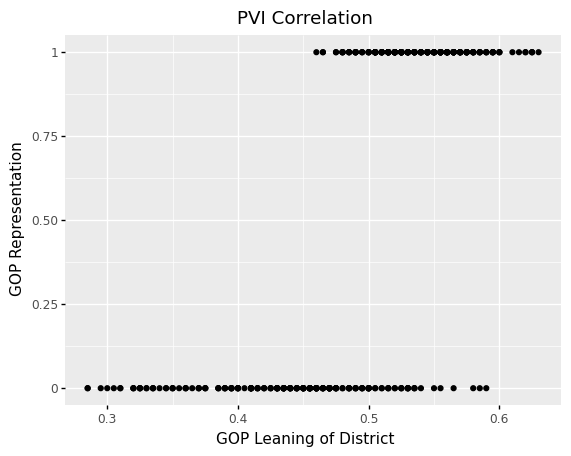

<ggplot: (8794007590379)>

In [16]:
# Create a super simple scatterplot to examine the relationship between PVI and congressional district
(p9.ggplot(data=pure_109, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y='GOP Representation',color="",title="PVI Correlation"))

In [17]:
#group by metric and average GOP seats
bm_109 = pure_109.groupby('metric').mean()
#this will not be produced into a dataset without aggregating all years, as 
bm_109 = bm_109.reset_index()

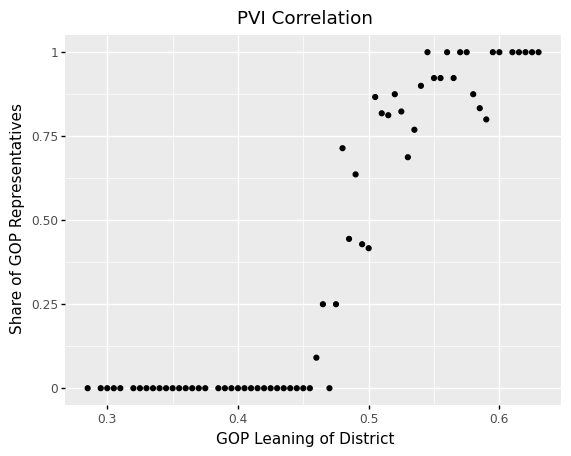

<ggplot: (8793974113380)>

In [18]:
#Plot averages
(p9.ggplot(data=bm_109, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

In [19]:
#now lets limit the data to only the R+10 to D+10 range, calling it Limited Domain
ld_109 = bm_109[bm_109["metric"] <= .55]
ld_109 = ld_109[ld_109["metric"] >= .45]

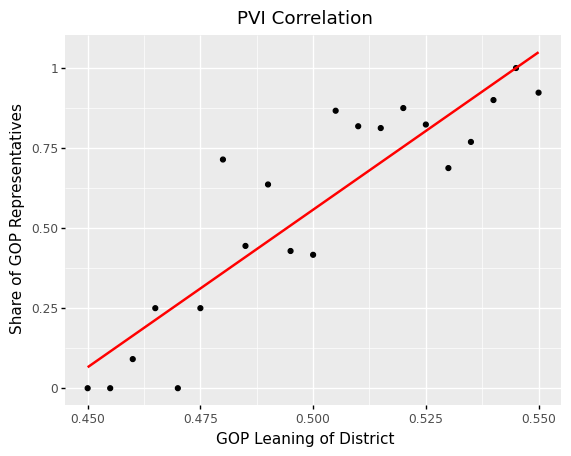

<ggplot: (8793974459200)>

In [20]:
#Plot averages
(p9.ggplot(data=ld_109, mapping=p9.aes(x='metric', y='is_GOP'))
 + p9.geom_point() 
 + geom_smooth(method = "lm", color = "red", se = False)
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))